In [148]:
import os
import json
import time
import pickle
import requests
import time
import warnings
import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot
from yellowbrick.target import ClassBalance

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

import sqlite3
import pandas as pd
import numpy as npa

In [149]:
def create_connection(db_file):
    """ 
    Create a database connection to the SQLite database as
    specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

In [150]:
conn = create_connection('C:/Users/Yaphet Tewahade/Cloudy-with-a-Chance-of-Football/fixtures/database/cloudy_with_a_chance_of_football.db')

In [151]:
cursorObj = conn.cursor()

In [152]:
cursorObj.execute('SELECT name from sqlite_master where type = "table"')
print(cursorObj.fetchall())

[('positions',), ('player_dob',), ('players',), ('player_team',), ('player_age',), ('team_home_time_zone',), ('injury_status',), ('days_since_last_game',), ('weather',), ('hours_displaced',), ('stats_regular',), ('stats_red_zone',), ('elevation_and_conference',), ('performance_target',)]


In [153]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [154]:
df = pd.read_sql_query(
        "SELECT * FROM injury_status", conn)

In [155]:
df

,PlayerID,week_id,injury_status
0,2593,2018_1,Probable
1,7242,2018_1,None
2,4314,2018_1,None
3,18857,2018_1,Questionable
4,16771,2018_1,None
...,...,...,...
39497,22477,2020_17,None
39498,22482,2020_17,None
39499,22485,2020_17,None
39500,21295,2020_17,None


In [156]:
#check for null values
print(f'There are {df.injury_status.nunique()} unique values in this column:')
df['injury_status'].unique()

There are 4 unique values in this column:


array(['Probable', None, 'Questionable', 'Out', 'Doubtful'], dtype=object)

In [157]:
# Fill in nulls with a status of 'healthy'
df['injury_status'] = df['injury_status'].fillna(value = 'Healthy')
print(f'There are now {df.injury_status.nunique()} unique values in this column:')
df['injury_status'].unique()

There are now 5 unique values in this column:


array(['Probable', 'Healthy', 'Questionable', 'Out', 'Doubtful'],
      dtype=object)

In [158]:
df.head()

,PlayerID,week_id,injury_status
0,2593,2018_1,Probable
1,7242,2018_1,Healthy
2,4314,2018_1,Healthy
3,18857,2018_1,Questionable
4,16771,2018_1,Healthy


In [159]:
df.tail()

,PlayerID,week_id,injury_status
39497,22477,2020_17,Healthy
39498,22482,2020_17,Healthy
39499,22485,2020_17,Healthy
39500,21295,2020_17,Healthy
39501,19763,2020_17,Healthy


In [160]:
X = df.drop('injury_status', axis = 1)
y = df['injury_status']

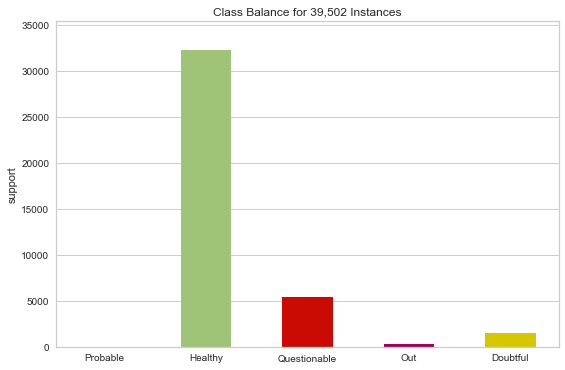

In [161]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=['Probable', 'Healthy','Questionable','Out','Doubtful'])

visualizer.fit(y) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [162]:

from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(31601, 2) (31601,)
(7901, 2) (7901,)


In [163]:

categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2)
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('estimator', estimator),
    
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [164]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2)
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Probable', 'Healthy','Questionable','Out','Doubtful'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

F1 SCORE SVC: 0.8152498607665435


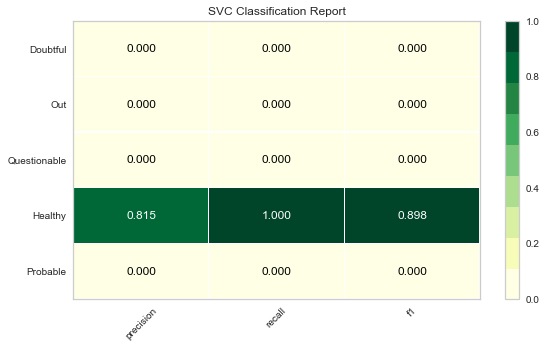

ValueError: b'specified nu is infeasible'

In [165]:
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

F1 SCORE SVC: 0.8165880826556121


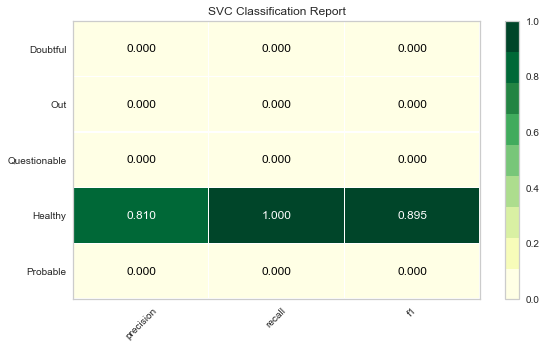

ValueError: b'specified nu is infeasible'

In [166]:
for model in models:
    score_model(X_train, y_train, model)
    visualize_model(X_test, y_test, model)